In [1]:
# TODO: introduce kelly criterion calculation
# TODO: introduce more leagues
# TODO: try to fit the names by assigning the same and then fix mismatches rather than sort

In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss

print(sys.version)
print(pd. __version__)
pd.set_option('display.max_columns', None)

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
1.5.3


In [3]:
GF = 1.2  # greed factor

In [4]:
# # international stuff

# df = pd.read_csv('/kaggle/input/fifaworldranking/fifa_ranking-2022-12-22.csv')
# print(len(df))
# df.head()

# # there was a major change in the ranking system in august 2018, leaving us effecively with 4 years of data
# df = df[df['rank_date'] >= '2019-01-01']
# df['year'] = df.apply(lambda x: x['rank_date'][:4], axis=1)

# new_df = df.copy()
# new_df.drop(columns=['rank', 'previous_points', 'rank_change', 'rank_date'], inplace=True)
# new_df = new_df.groupby(['country_full', 'country_abrv', 'confederation', 'year'], as_index=False).mean().round(2)
# new_df

In [5]:
def income_fun(row, GF):
    """Our function where we simulate betting on divergent results"""
    income = 0
    if row['EV_H'] >= GF:
        if row['H win'] == 1:
            income = income + row['OddsH'] - 1
        else:
            income -= 1
    if row['EV_D'] >= GF:
        if row['D win'] == 1:
            income = income + row['OddsD'] - 1
        else:
            income -= 1
    if row['EV_A'] >= GF:
        if row['A win'] == 1:
            income = income + row['OddsA'] - 1
        else:
            income -= 1
    return income

In [6]:
europe_df = pd.DataFrame()

file_names = ['B1', 'D1', 'E0', 'F1', 'G1', 'I1', 'N1', 'P1', 'SC0', 'SP1', 'T1']  # HARDCODED LEAGUE NAMES

for d in os.listdir('/kaggle/input/historical-odds/historicalodds'):
    if os.path.isdir(f'/kaggle/input/historical-odds/historicalodds/{d}'):
        print(d)
        for file_name in file_names:
            try:
                with open(f'/kaggle/input/historical-odds/historicalodds/{d}/{file_name}.csv') as f:
                    tmp_df = pd.read_csv(f)
                    tmp_df['season'] = d
                    europe_df = pd.concat([europe_df, tmp_df])
            except UnicodeDecodeError:
                print(f'Unicode error in {file_name}')
            except FileNotFoundError:
                pass
        
europe_df_raw = europe_df.copy()

2020
2017
2019
2022
2021
2016
2018
Unicode error in SC0


In [7]:
europe_df_raw

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,season,Referee,HFKC,AFKC,LBH,LBD,LBA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,Unnamed: 105
0,B1,08/08/2020,15:30,Club Brugge,Charleroi,0.0,1.0,A,0.0,0.0,D,17.0,6.0,5.0,4.0,10.0,11.0,10.0,2.0,2.0,3.0,0.0,0.0,1.50,3.80,6.00,1.50,4.00,6.50,1.53,3.80,6.00,1.53,4.13,6.81,1.50,4.00,6.50,1.53,4.0,6.50,1.59,4.33,7.10,1.52,4.00,6.26,1.95,1.85,1.93,1.90,2.00,1.99,1.91,1.87,-1.00,1.95,1.90,1.96,1.88,2.02,1.97,1.94,1.89,1.57,3.75,5.25,1.62,3.80,5.75,1.63,3.60,5.50,1.63,3.97,5.75,1.57,3.80,6.00,1.62,3.90,5.75,1.67,4.05,6.45,1.61,3.81,5.63,2.05,1.75,2.05,1.83,2.13,1.88,2.03,1.78,-0.75,1.77,2.10,1.82,2.09,1.85,2.12,1.79,2.06,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B1,08/08/2020,18:00,Antwerp,Mouscron,1.0,1.0,D,0.0,0.0,D,12.0,4.0,9.0,2.0,8.0,5.0,7.0,3.0,2.0,1.0,0.0,0.0,1.30,5.00,10.00,1.30,5.25,9.00,1.33,4.80,8.75,1.32,5.34,10.09,1.29,5.00,11.00,NaN,NaN,NaN,1.37,5.50,11.50,1.31,5.11,9.27,1.66,2.15,1.72,2.17,1.78,2.27,1.68,2.14,-1.50,2.00,1.85,2.09,1.79,2.12,1.90,1.99,1.84,1.44,4.20,6.00,1.48,4.60,6.25,1.47,4.10,6.25,1.52,4.41,6.35,1.44,4.50,6.50,1.45,4.60,7.00,1.52,5.13,7.70,1.46,4.42,6.52,1.70,2.10,1.73,2.19,1.78,2.27,1.69,2.13,-1.00,1.83,2.02,1.89,2.01,1.90,2.25,1.79,2.05,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B1,08/08/2020,18:00,Standard,Cercle Brugge,1.0,0.0,H,0.0,0.0,D,11.0,6.0,8.0,1.0,10.0,11.0,5.0,4.0,1.0,1.0,0.0,0.0,1.40,4.50,6.50,1.40,4.75,6.75,1.43,4.40,6.75,1.43,4.75,7.44,1.40,4.50,7.50,1.44,4.5,7.00,1.50,4.98,7.50,1.43,4.56,6.84,1.70,2.10,1.72,2.18,1.78,2.28,1.69,2.14,-1.25,2.00,1.85,2.03,1.82,2.06,1.90,1.98,1.85,1.45,4.50,6.50,1.48,4.40,6.75,1.45,4.10,6.75,1.51,4.16,7.25,1.44,4.33,7.00,1.50,4.33,6.50,1.54,4.65,7.50,1.48,4.26,6.60,1.72,2.07,1.77,2.12,1.83,2.19,1.73,2.09,-1.00,1.85,2.00,1.91,1.99,1.97,2.13,1.86,1.99,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B1,09/08/2020,12:30,St Truiden,Gent,2.0,1.0,H,1.0,1.0,D,11.0,13.0,8.0,2.0,19.0,13.0,6.0,3.0,2.0,2.0,0.0,0.0,4.50,3.80,1.65,4.60,4.00,1.67,4.30,3.85,1.70,4.54,4.19,1.72,4.33,4.00,1.70,NaN,NaN,NaN,4.70,4.50,1.76,4.36,4.05,1.70,1.53,2.40,1.56,2.47,1.57,2.53,1.54,2.43,0.75,1.93,1.93,1.96,1.88,1.97,1.97,1.93,1.89,5.5,4.00,1.60,4.50,4.25,1.62,4.90,3.80,1.63,5.05,4.13,1.66,5.25,4.00,1.60,5.25,4.10,1.62,5.55,4.33,1.69,4.96,4.02,1.63,1.75,2.05,1.81,2.07,1.82,2.21,1.73,2.09,0.75,2.05,1.80,2.06,1.84,2.13,1.85,2.04,1.81,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B1,09/08/2020,15:00,Waregem,Genk,1.0,2.0,A,1.0,0.0,H,8.0,15.0,6.0,4.0,15.0,16.0,9.0,8.0,3.0,1.0,0.0,0.0,3.75,3.60,1.90,3.70,3.75,1.87,3.45,3.65,1.95,3.65,3.91,1.97,3.50,3.80,1.91,NaN,NaN,NaN,3.75,4.20,2.01,3.52,3.79,1.93,1.50,2.50,1.53,2.57,1.53,2.60,1.49,2.52,0.50,1.93,1.93,1.91,1.94,1.97,1.98,1.89,1.92,3.8,4.00,1.80,3.60,3.75,1.90,3.65,3.65,1.85,3.99,4.03,1.85,3.75,3.90,1.83,4.00,3.90,1.85,4.05,4.15,2.66,3.79,3.88,1.85,1.53,2.40,1.58,2.48,1.93,2.60,1.54,2.43,0.50,2.05,1.80,2.05,1.85,2.10,1.87,2.01,1.83,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [8]:
def get_odds(row, w):
    if not np.isnan(row[f'Avg{w}']):
        return row[f'Avg{w}']
    elif not np.isnan(row[f'B365{w}']):
        return row[f'B365{w}']
    else:
        return np.nan
    
for p in ['H', 'D', 'A']:
    europe_df[f'Odds{p}'] = europe_df.apply(get_odds, args=(p,), axis=1)

europe_df = europe_df[['Div', 'HomeTeam', 'AwayTeam', 'OddsH', 'OddsD', 'OddsA', 'season']]
europe_df.dropna(inplace=True)
europe_df

,Div,HomeTeam,AwayTeam,OddsH,OddsD,OddsA,season
0,B1,Club Brugge,Charleroi,1.52,4.00,6.26,2020
1,B1,Antwerp,Mouscron,1.31,5.11,9.27,2020
2,B1,Standard,Cercle Brugge,1.43,4.56,6.84,2020
3,B1,St Truiden,Gent,4.36,4.05,1.70,2020
4,B1,Waregem,Genk,3.52,3.79,1.93,2020
...,...,...,...,...,...,...,...
301,T1,Konyaspor,Akhisar Belediyespor,1.45,4.50,6.50,2018
302,T1,Fenerbahce,Antalyaspor,1.66,4.00,4.75,2018
303,T1,Goztep,Ankaragucu,1.36,4.75,8.00,2018
304,T1,Kayserispor,Erzurum BB,2.62,3.40,2.55,2018


In [9]:
# ['B1', 'D1', 'E0', 'F1', 'G1', 'I1', 'N1', 'P1', 'SC0', 'SP1', 'T1']
B1_ID = 1832  # Belgium ok
D1_ID = 1845  # Germany ok
E0_ID = 2411  # England ok
F1_ID = 1843  # France ok
G1_ID = 1884  # Greece ok
I1_ID = 1854  # Italy ok
N1_ID = 1849  # Netherlands ok
P1_ID = 1864  # Portugal ok
SC0_ID = 2417  # Scotland
SP1_ID = 1869  # Spain ok
T1_ID = 1882  # Turkey ok
IDS = [B1_ID, D1_ID, E0_ID, F1_ID, G1_ID, I1_ID, N1_ID, P1_ID, SC0_ID, SP1_ID, T1_ID]    # HARDCODED LEAGUE IDS
spi_matches = pd.read_csv('/kaggle/input/soccer-spi-28052023/spi_matches.csv')
spi_matches = spi_matches[spi_matches['league_id'].isin(IDS)]
spi_matches = spi_matches[['league_id', 'season', 'team1', 'team2', 'prob1', 'prob2', 'probtie', 'score1', 'score2']]
spi_matches.dropna(inplace=True)
spi_matches

,league_id,season,team1,team2,prob1,prob2,probtie,score1,score2
10,1843,2016,Bastia,Paris Saint-Germain,0.0463,0.8380,0.1157,0.0,1.0
11,1843,2016,AS Monaco,Guingamp,0.5714,0.1669,0.2617,2.0,2.0
12,2411,2016,Hull City,Leicester City,0.3459,0.3621,0.2921,2.0,1.0
13,2411,2016,Southampton,Watford,0.5759,0.1874,0.2367,1.0,1.0
14,2411,2016,Crystal Palace,West Bromwich Albion,0.4214,0.2939,0.2847,0.0,1.0
...,...,...,...,...,...,...,...,...,...
67110,1843,2022,Clermont Foot,Lorient,0.4226,0.2993,0.2781,2.0,0.0
67111,1843,2022,Montpellier,Nice,0.3749,0.3502,0.2749,2.0,3.0
67112,1843,2022,Marseille,Brest,0.5203,0.2354,0.2443,1.0,2.0
67113,1843,2022,Strasbourg,Paris Saint-Germain,0.3318,0.4428,0.2255,1.0,1.0


In [10]:
# DATA CLEANING PART

# B1

b1_df = europe_df[europe_df['Div'] == 'B1']
b1_spi = spi_matches[spi_matches['league_id'] == B1_ID]

odds_names = sorted(b1_df['HomeTeam'].unique())
spi_names = sorted(b1_spi['team1'].unique())
b1_dict = {k: v for (k, v) in zip(odds_names, spi_names)}
b1_dict['Beerschot VA'] = 'KFCO Beerschot-Wilrijk'
b1_dict['Cercle Brugge'] = 'Cercle Brugge'
b1_dict['Charleroi'] = 'Sporting de Charleroi'
b1_dict['Club Brugge'] = 'Club Brugge'
b1_dict['Eupen'] = 'Eupen'
b1_dict['Cercle Brugge'] = 'Cercle Brugge'
b1_dict['Genk'] = 'Genk'
b1_dict['Gent'] = 'KAA Gent'
b1_dict['Lokeren'] = 'KSC Lokeren'
b1_dict['Mechelen'] = 'KV Mechelen'
b1_dict['Mouscron'] = 'Mouscron-Peruwelz'
b1_dict['Oostende'] = 'KV Oostende'
b1_dict['St Truiden'] = 'St. Truidense'
b1_dict['St. Gilloise'] = 'Union Saint Gilloise'
b1_dict['Standard'] = 'Standard Liege'
b1_dict['Waasland-Beveren'] = 'Waasland-Beveren'
b1_dict['Waregem'] = 'SV Zulte Waregem'
b1_dict['Westerlo'] = 'KVC Westerlo'
# b1_dict

In [11]:
# D1

d1_df = europe_df[europe_df['Div'] == 'D1']
d1_spi = spi_matches[spi_matches['league_id'] == D1_ID]

odds_names = sorted(d1_df['HomeTeam'].unique())
spi_names = sorted(d1_spi['team1'].unique())
d1_dict = {k: v for (k, v) in zip(odds_names, spi_names)}
d1_dict['Augsburg'] = 'FC Augsburg'
d1_dict['Bayern Munich'] = 'Bayern Munich'
d1_dict['Bochum'] = 'VfL Bochum'
d1_dict['Darmstadt'] = 'SV Darmstadt 98'
d1_dict['Ein Frankfurt'] = 'Eintracht Frankfurt'
d1_dict['FC Koln'] = 'FC Cologne'
d1_dict['Fortuna Dusseldorf'] = 'Fortuna Düsseldorf'
d1_dict['Freiburg'] = 'SC Freiburg'
d1_dict['Greuther Furth'] = 'SpVgg Greuther Fürth'
d1_dict['Hamburg'] = 'Hamburg SV'
d1_dict['Hannover'] = 'Hannover 96'
d1_dict['Hertha'] = 'Hertha Berlin'
d1_dict['Hoffenheim'] = 'TSG Hoffenheim'
d1_dict['Ingolstadt'] = 'FC Ingolstadt 04'
d1_dict['Leverkusen'] = 'Bayer Leverkusen'
d1_dict['M\'gladbach'] = 'Borussia Monchengladbach'
d1_dict['Mainz'] = 'Mainz'
d1_dict['Nurnberg'] = '1. FC Nürnberg'
d1_dict['Paderborn'] = 'SC Paderborn'
d1_dict['RB Leipzig'] = 'RB Leipzig'
d1_dict['Schalke 04'] = 'Schalke 04'
d1_dict['Union Berlin'] = '1. FC Union Berlin'
d1_dict['Werder Bremen'] = 'Werder Bremen'
d1_dict['Wolfsburg'] = 'VfL Wolfsburg'
# d1_dict

In [12]:
# E0

english_df = europe_df[europe_df['Div'] == 'E0']
english_spi = spi_matches[spi_matches['league_id'] == E0_ID]

odds_names = sorted(english_df['HomeTeam'].unique())
spi_names = sorted(english_spi['team1'].unique())
e0_dict = {k: v for (k, v) in zip(odds_names, spi_names)}
e0_dict['Arsenal'] = 'Arsenal'
e0_dict['Aston Villa'] = 'Aston Villa'
e0_dict['Bournemouth'] = 'AFC Bournemouth'
# e0_dict

In [13]:
# F1

f1_df = europe_df[europe_df['Div'] == 'F1']
f1_spi = spi_matches[spi_matches['league_id'] == F1_ID]

odds_names = sorted(f1_df['HomeTeam'].unique())
spi_names = sorted(f1_spi['team1'].unique())
f1_dict = {k: k for k in odds_names}

print([s for s in spi_names if s not in f1_dict.values()])

f1_dict['Ajaccio'] = 'AC Ajaccio'
f1_dict['Monaco'] = 'AS Monaco'
f1_dict['Nancy'] = 'AS Nancy Lorraine'
f1_dict['Clermont'] = 'Clermont Foot'
f1_dict['Dijon'] = 'Dijon FCO'
f1_dict['Paris SG'] = 'Paris Saint-Germain'
f1_dict['Rennes'] = 'Stade Rennes'

print([s for s in spi_names if s not in f1_dict.values()])

# f1_dict

['AC Ajaccio', 'AS Monaco', 'AS Nancy Lorraine', 'Clermont Foot', 'Dijon FCO', 'Paris Saint-Germain', 'Stade Rennes']
[]


In [14]:
# G1

g1_df = europe_df[europe_df['Div'] == 'G1']
g1_spi = spi_matches[spi_matches['league_id'] == G1_ID]

odds_names = sorted(g1_df['HomeTeam'].unique())
spi_names = sorted(g1_spi['team1'].unique())
g1_dict = {k: k for k in odds_names}

print([s for s in spi_names if s not in g1_dict.values()])

g1_dict['AEK'] = 'AEK Athens'
g1_dict['Apollon'] = 'Apollon Smyrni'
g1_dict['Apollon Apollon'] = 'Apollon Smyrni'
g1_dict['Aris'] = 'Aris Salonika'
g1_dict['Xanthi'] = 'FC Xanthi'
g1_dict['Ionikos'] = 'Ionikos FC'
g1_dict['Larisa'] = 'Larissa'
g1_dict['Levadeiakos'] = 'Levadiakos'
g1_dict['Olympiakos'] = 'Olympiacos'
g1_dict['PAOK'] = 'PAOK Salonika'

print([s for s in spi_names if s not in g1_dict.values()])

# g1_dict

['AEK Athens', 'Apollon Smyrni', 'Aris Salonika', 'FC Xanthi', 'Ionikos FC', 'Larissa', 'Levadiakos', 'Olympiacos', 'PAOK Salonika']
[]


In [15]:
# I1

i1_df = europe_df[europe_df['Div'] == 'I1']
i1_spi = spi_matches[spi_matches['league_id'] == I1_ID]

odds_names = sorted(i1_df['HomeTeam'].unique())
spi_names = sorted(i1_spi['team1'].unique())
i1_dict = {k: k for k in odds_names}

print([s for s in spi_names if s not in i1_dict.values()])

i1_dict['Milan'] = 'AC Milan'
i1_dict['Roma'] = 'AS Roma'
i1_dict['Chievo'] = 'Chievo Verona'
i1_dict['Venezia'] = 'F.B.C Unione Venezia'
i1_dict['Inter'] = 'Internazionale'
i1_dict['Pescara'] = 'US Pescara'

print([s for s in spi_names if s not in i1_dict.values()])

# i1_dict

['AC Milan', 'AS Roma', 'Chievo Verona', 'F.B.C Unione Venezia', 'Internazionale', 'US Pescara']
[]


In [16]:
# N1

n1_df = europe_df[europe_df['Div'] == 'N1']
n1_spi = spi_matches[spi_matches['league_id'] == N1_ID]

odds_names = sorted(n1_df['HomeTeam'].unique())
spi_names = sorted(n1_spi['team1'].unique())
n1_dict = {k: k for k in odds_names}

print([s for s in spi_names if s not in n1_dict.values()])

n1_dict['Den Haag'] = 'ADO Den Haag'
n1_dict['AZ Alkmaar'] = 'AZ'
n1_dict['Cambuur'] = 'Cambuur Leeuwarden'
n1_dict['Graafschap'] = 'De Graafschap'
n1_dict['FC Emmen'] = 'Emmen'
n1_dict['Groningen'] = 'FC Groningen'
n1_dict['Twente'] = 'FC Twente'
n1_dict['Utrecht'] = 'FC Utrecht'
n1_dict['Volendam'] = 'FC Volendam'
n1_dict['For Sittard'] = 'Fortuna Sittard'
n1_dict['NAC Breda'] = 'NAC'
n1_dict['Nijmegen'] = 'NEC'
n1_dict['Zwolle'] = 'PEC Zwolle'
n1_dict['PSV Eindhoven'] = 'PSV'
n1_dict['Waalwijk'] = 'RKC'
n1_dict['Roda'] = 'Roda JC'
n1_dict['Sparta Rotterdam'] = 'Sparta'

print([s for s in spi_names if s not in n1_dict.values()])

# n1_dict

['ADO Den Haag', 'AZ', 'Cambuur Leeuwarden', 'De Graafschap', 'Emmen', 'FC Groningen', 'FC Twente', 'FC Utrecht', 'FC Volendam', 'Fortuna Sittard', 'NAC', 'NEC', 'PEC Zwolle', 'PSV', 'RKC', 'Roda JC', 'Sparta']
[]


In [17]:
# P1

p1_df = europe_df[europe_df['Div'] == 'P1']
p1_spi = spi_matches[spi_matches['league_id'] == P1_ID]

odds_names = sorted(p1_df['HomeTeam'].unique())
spi_names = sorted(p1_spi['team1'].unique())
p1_dict = {k: k for k in odds_names}

print([s for s in spi_names if s not in p1_dict.values()])

p1_dict['Sp Braga'] = 'Braga'
p1_dict['Nacional'] = 'C.D. Nacional'
p1_dict['Aves'] = 'Desportivo Aves'
p1_dict['Estoril'] = 'Estoril Praia'
p1_dict['Arouca'] = 'FC Arouca'
p1_dict['Porto'] = 'FC Porto'
p1_dict['Farense'] = 'SC Farense'
p1_dict['Sp Lisbon'] = 'Sporting CP'
p1_dict['Setubal'] = 'Vitoria Setubal'

print([s for s in spi_names if s not in p1_dict.values()])

# p1_dict

['Braga', 'C.D. Nacional', 'Desportivo Aves', 'Estoril Praia', 'FC Arouca', 'FC Porto', 'SC Farense', 'Sporting CP', 'Vitoria Setubal']
[]


In [18]:
# SC0

sc0_df = europe_df[europe_df['Div'] == 'SC0']
sc0_spi = spi_matches[spi_matches['league_id'] == SC0_ID]

odds_names = sorted(sc0_df['HomeTeam'].unique())
spi_names = sorted(sc0_spi['team1'].unique())
sc0_dict = {k: k for k in odds_names}

print([s for s in spi_names if s not in sc0_dict.values()])

sc0_dict['Dundee United'] = 'Dundee Utd'
sc0_dict['Hamilton'] = 'Hamilton Academical'
sc0_dict['Partick'] = 'Partick Thistle'

print([s for s in spi_names if s not in sc0_dict.values()])

# sc0_dict

['Dundee Utd', 'Hamilton Academical', 'Partick Thistle']
[]


In [19]:
# SP1

spanish_df = europe_df[europe_df['Div'] == 'SP1']
spanish_spi = spi_matches[spi_matches['league_id'] == SP1_ID]

odds_names = sorted(spanish_df['HomeTeam'].unique())
spi_names = sorted(spanish_spi['team1'].unique())
sp1 = {k: v for (k, v) in zip(odds_names, spi_names)}

sp1['Betis'] = 'Real Betis'
sp1['Cadiz'] = 'Cadiz'
sp1['Celta'] = 'Celta Vigo'
sp1['Huesca'] = 'SD Huesca'
sp1['La Coruna'] = 'Deportivo La Coruña'
sp1['Las Palmas'] = 'Las Palmas'
sp1['Leganes'] = 'Leganes'
sp1['Levante'] = 'Levante'
sp1['Malaga'] = 'Málaga'
sp1['Mallorca'] = 'Mallorca'
sp1['Osasuna'] = 'Osasuna'
sp1['Sevilla'] = 'Sevilla FC'
sp1['Sociedad'] = 'Real Sociedad'
sp1['Sp Gijon'] = 'Sporting Gijón'
sp1['Valencia'] = 'Valencia'
sp1['Valladolid'] = 'Real Valladolid'
sp1['Vallecano'] = 'Rayo Vallecano'
# sp1

In [20]:
# T1

t1_df = europe_df[europe_df['Div'] == 'T1']
t1_spi = spi_matches[spi_matches['league_id'] == T1_ID]

odds_names = sorted(t1_df['HomeTeam'].unique())
spi_names = sorted(t1_spi['team1'].unique())
t1_dict = {k: k for k in odds_names}

print([s for s in spi_names if s not in t1_dict.values()])

t1_dict['Ad. Demirspor'] = 'Adana Demirspor'
t1_dict['Akhisar Belediyespor'] = 'Akhisar Belediye'
t1_dict['Osmanlispor'] = 'Ankaraspor'  # sic
t1_dict['Rizespor'] = 'Caykur Rizespor'
t1_dict['Erzurum BB'] = 'Erzurumspor'
t1_dict['Karagumruk'] = 'Fatih Karagümrük'
t1_dict['Gaziantep'] = 'Gazisehir Gaziantep'
t1_dict['Goztep'] = 'Goztepe'
t1_dict['Buyuksehyr'] = 'Istanbul Basaksehir'  # sic
t1_dict['Karabukspor'] = 'Karabükspor'

print([s for s in spi_names if s not in t1_dict.values()])

# t1_dict

['Adana Demirspor', 'Akhisar Belediye', 'Ankaraspor', 'Caykur Rizespor', 'Erzurumspor', 'Fatih Karagümrük', 'Gazisehir Gaziantep', 'Goztepe', 'Istanbul Basaksehir', 'Karabükspor']
[]


In [21]:
names_dict = b1_dict | d1_dict | e0_dict | f1_dict | g1_dict | i1_dict | n1_dict | p1_dict | sc0_dict | sp1 | t1_dict
len(set(names_dict.values()))

295

In [22]:
europe_df['HomeTeam'] = europe_df['HomeTeam'].apply(lambda x: names_dict[x])
europe_df['AwayTeam'] = europe_df['AwayTeam'].apply(lambda x: names_dict[x])
europe_df['BookieProbH'] = europe_df.apply(lambda row: 1/row['OddsH'] / (1/row['OddsH'] + 1/row['OddsD'] + 1/row['OddsA']), axis=1)
europe_df['BookieProbD'] = europe_df.apply(lambda row: 1/row['OddsD'] / (1/row['OddsH'] + 1/row['OddsD'] + 1/row['OddsA']), axis=1)
europe_df['BookieProbA'] = europe_df.apply(lambda row: 1/row['OddsA'] / (1/row['OddsH'] + 1/row['OddsD'] + 1/row['OddsA']), axis=1)
europe_df['KEY'] = europe_df.apply(lambda row: f"{row['HomeTeam']} x {row['AwayTeam']} x {row['season']}", axis=1)
europe_df

,Div,HomeTeam,AwayTeam,OddsH,OddsD,OddsA,season,BookieProbH,BookieProbD,BookieProbA,KEY
0,B1,Club Brugge,Sporting de Charleroi,1.52,4.00,6.26,2020,0.616215,0.234162,0.149624,Club Brugge x Sporting de Charleroi x 2020
1,B1,Antwerp,Mouscron-Peruwelz,1.31,5.11,9.27,2020,0.715473,0.183419,0.101108,Antwerp x Mouscron-Peruwelz x 2020
2,B1,Standard Liege,Cercle Brugge,1.43,4.56,6.84,2020,0.656745,0.205953,0.137302,Standard Liege x Cercle Brugge x 2020
3,B1,St. Truidense,KAA Gent,4.36,4.05,1.70,2020,0.215459,0.231951,0.552590,St. Truidense x KAA Gent x 2020
4,B1,SV Zulte Waregem,Genk,3.52,3.79,1.93,2020,0.266482,0.247498,0.486020,SV Zulte Waregem x Genk x 2020
...,...,...,...,...,...,...,...,...,...,...,...
301,T1,Konyaspor,Akhisar Belediye,1.45,4.50,6.50,2018,0.647124,0.208518,0.144358,Konyaspor x Akhisar Belediye x 2018
302,T1,Fenerbahce,Antalyaspor,1.66,4.00,4.75,2018,0.566741,0.235198,0.198061,Fenerbahce x Antalyaspor x 2018
303,T1,Goztepe,Ankaragucu,1.36,4.75,8.00,2018,0.686664,0.196603,0.116733,Goztepe x Ankaragucu x 2018
304,T1,Kayserispor,Erzurumspor,2.62,3.40,2.55,2018,0.357393,0.275403,0.367204,Kayserispor x Erzurumspor x 2018


In [23]:
spi_matches['H win'] = spi_matches.apply(lambda row: 1 if row['score1'] > row['score2'] else 0, axis=1)
spi_matches['D win'] = spi_matches.apply(lambda row: 1 if row['score1'] == row['score2'] else 0, axis=1)
spi_matches['A win'] = spi_matches.apply(lambda row: 1 if row['score1'] < row['score2'] else 0, axis=1)
spi_matches['KEY'] = spi_matches.apply(lambda row: f"{row['team1']} x {row['team2']} x {row['season']}", axis=1)
spi_matches

,league_id,season,team1,team2,prob1,prob2,probtie,score1,score2,H win,D win,A win,KEY
10,1843,2016,Bastia,Paris Saint-Germain,0.0463,0.8380,0.1157,0.0,1.0,0,0,1,Bastia x Paris Saint-Germain x 2016
11,1843,2016,AS Monaco,Guingamp,0.5714,0.1669,0.2617,2.0,2.0,0,1,0,AS Monaco x Guingamp x 2016
12,2411,2016,Hull City,Leicester City,0.3459,0.3621,0.2921,2.0,1.0,1,0,0,Hull City x Leicester City x 2016
13,2411,2016,Southampton,Watford,0.5759,0.1874,0.2367,1.0,1.0,0,1,0,Southampton x Watford x 2016
14,2411,2016,Crystal Palace,West Bromwich Albion,0.4214,0.2939,0.2847,0.0,1.0,0,0,1,Crystal Palace x West Bromwich Albion x 2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67110,1843,2022,Clermont Foot,Lorient,0.4226,0.2993,0.2781,2.0,0.0,1,0,0,Clermont Foot x Lorient x 2022
67111,1843,2022,Montpellier,Nice,0.3749,0.3502,0.2749,2.0,3.0,0,0,1,Montpellier x Nice x 2022
67112,1843,2022,Marseille,Brest,0.5203,0.2354,0.2443,1.0,2.0,0,0,1,Marseille x Brest x 2022
67113,1843,2022,Strasbourg,Paris Saint-Germain,0.3318,0.4428,0.2255,1.0,1.0,0,1,0,Strasbourg x Paris Saint-Germain x 2022


In [24]:
df = europe_df.merge(spi_matches, on='KEY', how='inner')
df.drop(columns=['team1', 'team2'], inplace=True)
df

,Div,HomeTeam,AwayTeam,OddsH,OddsD,OddsA,season_x,BookieProbH,BookieProbD,BookieProbA,KEY,league_id,season_y,prob1,prob2,probtie,score1,score2,H win,D win,A win
0,B1,Club Brugge,Sporting de Charleroi,1.52,4.00,6.26,2020,0.616215,0.234162,0.149624,Club Brugge x Sporting de Charleroi x 2020,1832,2020,0.6516,0.1283,0.2201,0.0,1.0,0,0,1
1,B1,Antwerp,Mouscron-Peruwelz,1.31,5.11,9.27,2020,0.715473,0.183419,0.101108,Antwerp x Mouscron-Peruwelz x 2020,1832,2020,0.5693,0.1831,0.2477,1.0,1.0,0,1,0
2,B1,Standard Liege,Cercle Brugge,1.43,4.56,6.84,2020,0.656745,0.205953,0.137302,Standard Liege x Cercle Brugge x 2020,1832,2020,0.6592,0.1316,0.2092,1.0,0.0,1,0,0
3,B1,St. Truidense,KAA Gent,4.36,4.05,1.70,2020,0.215459,0.231951,0.552590,St. Truidense x KAA Gent x 2020,1832,2020,0.2581,0.5019,0.2401,2.0,1.0,1,0,0
4,B1,SV Zulte Waregem,Genk,3.52,3.79,1.93,2020,0.266482,0.247498,0.486020,SV Zulte Waregem x Genk x 2020,1832,2020,0.3032,0.4619,0.2349,1.0,2.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22931,T1,Konyaspor,Akhisar Belediye,1.45,4.50,6.50,2018,0.647124,0.208518,0.144358,Konyaspor x Akhisar Belediye x 2018,1882,2018,0.4666,0.2455,0.2879,0.0,0.0,0,1,0
22932,T1,Fenerbahce,Antalyaspor,1.66,4.00,4.75,2018,0.566741,0.235198,0.198061,Fenerbahce x Antalyaspor x 2018,1882,2018,0.5056,0.2471,0.2473,3.0,1.0,1,0,0
22933,T1,Goztepe,Ankaragucu,1.36,4.75,8.00,2018,0.686664,0.196603,0.116733,Goztepe x Ankaragucu x 2018,1882,2018,0.5966,0.1583,0.2451,2.0,1.0,1,0,0
22934,T1,Kayserispor,Erzurumspor,2.62,3.40,2.55,2018,0.357393,0.275403,0.367204,Kayserispor x Erzurumspor x 2018,1882,2018,0.4260,0.3000,0.2740,0.0,2.0,0,0,1


In [25]:
bookie_log_loss_H = log_loss(df['H win'].tolist(), df['BookieProbH'].tolist())
bookie_log_loss_D = log_loss(df['D win'].tolist(), df['BookieProbD'].tolist())
bookie_log_loss_A = log_loss(df['A win'].tolist(), df['BookieProbA'].tolist())
print(bookie_log_loss_H)
print(bookie_log_loss_D)
print(bookie_log_loss_A)

spi_log_loss_H = log_loss(df['H win'].tolist(), df['prob1'].tolist())
spi_log_loss_D = log_loss(df['D win'].tolist(), df['probtie'].tolist())
spi_log_loss_A = log_loss(df['A win'].tolist(), df['prob2'].tolist())
print(spi_log_loss_H)
print(spi_log_loss_D)
print(spi_log_loss_A)

df['EV_H'] = df.apply(lambda row: row['OddsH'] * row['prob1'], axis=1)
df['EV_D'] = df.apply(lambda row: row['OddsD'] * row['probtie'], axis=1)
df['EV_A'] = df.apply(lambda row: row['OddsA'] * row['prob2'], axis=1)
df.to_csv('europe_df.csv')
df

0.6013824406802356
0.5471778480388805
0.5376517298527327
0.6098550927370548
0.5495384650186633
0.545077117662927


,Div,HomeTeam,AwayTeam,OddsH,OddsD,OddsA,season_x,BookieProbH,BookieProbD,BookieProbA,KEY,league_id,season_y,prob1,prob2,probtie,score1,score2,H win,D win,A win,EV_H,EV_D,EV_A
0,B1,Club Brugge,Sporting de Charleroi,1.52,4.00,6.26,2020,0.616215,0.234162,0.149624,Club Brugge x Sporting de Charleroi x 2020,1832,2020,0.6516,0.1283,0.2201,0.0,1.0,0,0,1,0.990432,0.880400,0.803158
1,B1,Antwerp,Mouscron-Peruwelz,1.31,5.11,9.27,2020,0.715473,0.183419,0.101108,Antwerp x Mouscron-Peruwelz x 2020,1832,2020,0.5693,0.1831,0.2477,1.0,1.0,0,1,0,0.745783,1.265747,1.697337
2,B1,Standard Liege,Cercle Brugge,1.43,4.56,6.84,2020,0.656745,0.205953,0.137302,Standard Liege x Cercle Brugge x 2020,1832,2020,0.6592,0.1316,0.2092,1.0,0.0,1,0,0,0.942656,0.953952,0.900144
3,B1,St. Truidense,KAA Gent,4.36,4.05,1.70,2020,0.215459,0.231951,0.552590,St. Truidense x KAA Gent x 2020,1832,2020,0.2581,0.5019,0.2401,2.0,1.0,1,0,0,1.125316,0.972405,0.853230
4,B1,SV Zulte Waregem,Genk,3.52,3.79,1.93,2020,0.266482,0.247498,0.486020,SV Zulte Waregem x Genk x 2020,1832,2020,0.3032,0.4619,0.2349,1.0,2.0,0,0,1,1.067264,0.890271,0.891467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22931,T1,Konyaspor,Akhisar Belediye,1.45,4.50,6.50,2018,0.647124,0.208518,0.144358,Konyaspor x Akhisar Belediye x 2018,1882,2018,0.4666,0.2455,0.2879,0.0,0.0,0,1,0,0.676570,1.295550,1.595750
22932,T1,Fenerbahce,Antalyaspor,1.66,4.00,4.75,2018,0.566741,0.235198,0.198061,Fenerbahce x Antalyaspor x 2018,1882,2018,0.5056,0.2471,0.2473,3.0,1.0,1,0,0,0.839296,0.989200,1.173725
22933,T1,Goztepe,Ankaragucu,1.36,4.75,8.00,2018,0.686664,0.196603,0.116733,Goztepe x Ankaragucu x 2018,1882,2018,0.5966,0.1583,0.2451,2.0,1.0,1,0,0,0.811376,1.164225,1.266400
22934,T1,Kayserispor,Erzurumspor,2.62,3.40,2.55,2018,0.357393,0.275403,0.367204,Kayserispor x Erzurumspor x 2018,1882,2018,0.4260,0.3000,0.2740,0.0,2.0,0,0,1,1.116120,0.931600,0.765000


In [26]:
results = []

for el in np.arange(0, 3, 0.1):
    GF = el
    df['Income'] = df.apply(income_fun, args=(GF,), axis=1)
    income_sum = sum(df['Income'])
    df['Number of bets'] = df.apply(lambda row: len([el for el in [row['EV_H'], row['EV_D'], row['EV_A']] if el >= GF]), axis=1)
    no_bets = sum(df['Number of bets'])
    results.append([GF, income_sum, no_bets, income_sum/no_bets])
#     print(f'Income: {income_sum}')
#     print(f'Number of bets: {no_bets}')
#     print(f'ROI: {income_sum/no_bets}')
#     print()

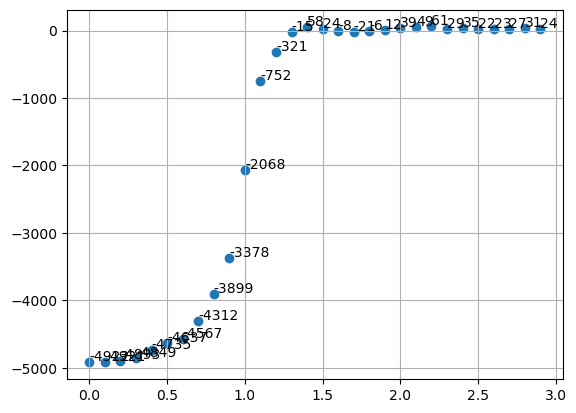

In [27]:
# Absolute income

offset = 20

plt.figure()
plt.grid(True)
plt.scatter([r[0] for r in results], [r[1] for r in results])

for r in results:
    plt.text(r[0], r[1] + offset, f'{int(round(r[1]))}')

# plt.bar([r[0] for r in results], [r[2] for r in results])
# plt.plot([r[0] for r in results], [r[3] for r in results])
plt.show()

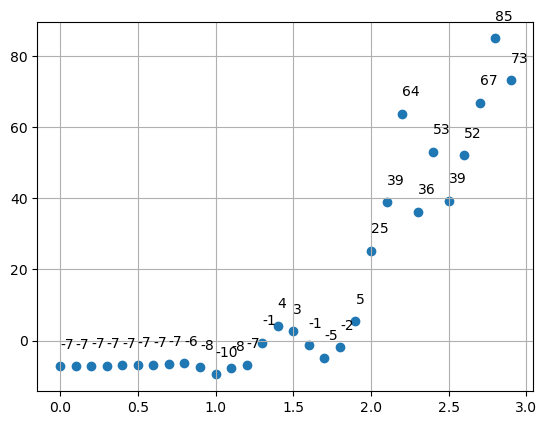

In [28]:
# ROI

offset = 5

plt.figure()
plt.grid(True)
plt.scatter([r[0] for r in results], [r[3] * 100 for r in results])

for r in results:
    plt.text(r[0], r[3] * 100 + offset, f'{int(round(r[3] * 100, 0))}')

plt.show()

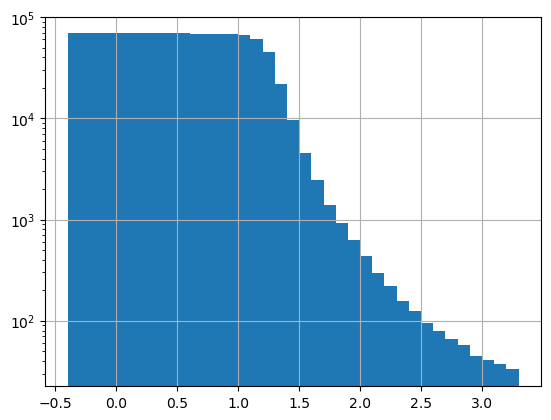

In [29]:
# number of bets

offset = 20

plt.figure()
plt.grid(True)
plt.bar([r[0] for r in results], [r[2] for r in results])
plt.yscale('log')
plt.show()

In [30]:
df['sum of goals'] = df.apply(lambda row: row['score1'] + row['score2'], axis=1)

In [31]:
sum_of_goals = df['sum of goals'].value_counts().sort_index().to_frame()
sum_of_goals['%'] = sum_of_goals.apply(lambda row: row['sum of goals'] / sum(sum_of_goals['sum of goals']), axis=1)
sum_of_goals

,sum of goals,%
0.0,1598,0.069672
1.0,3845,0.167640
2.0,5457,0.237923
3.0,5129,0.223622
4.0,3484,0.151901
5.0,1993,0.086894
6.0,890,0.038804
7.0,362,0.015783
8.0,132,0.005755
9.0,35,0.001526


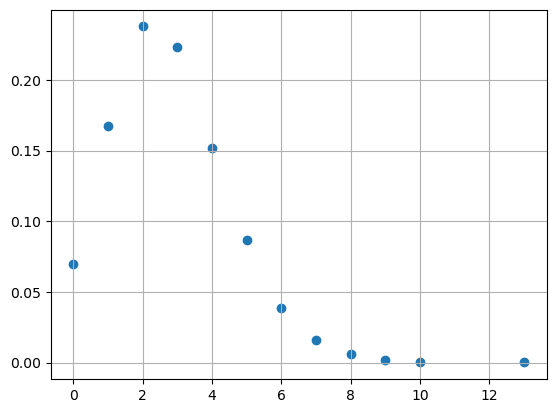

In [32]:
plt.figure()
plt.grid(True)
plt.scatter(sum_of_goals.index, sum_of_goals['%'])
plt.show()